In [ ]:
#   importing required libraries

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from skimage.transform import resize
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from skimage.measure import label, regionprops
from scipy.spatial.distance import cosine

In [ ]:
#   Loading and Preprocessing Brain Tumor MRI Dataset by Masoud Nickparvar
#   Dataset Link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=224

for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

for label in labels:
    path = os.path.join(test_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
#   Number of sample = 7023
X_train.shape

(7023, 224, 224, 3)

In [ ]:
#   Shuffling data

X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_train.shape

(7023, 224, 224, 3)

In [ ]:
#   Plotting the images

plt.figure(figsize=(8,8))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis("off")
plt.show()

In [ ]:
#   Split the data into training and testing and validation

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [ ]:
#   Data Augmentation and One-Hot Encoding of Labels

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

y_train_new = to_categorical(Y_train, num_classes=4)
y_valid_new = to_categorical(Y_valid, num_classes=4)
y_test_new = to_categorical(Y_test, num_classes=4)


In [ ]:
#   Defining and Compiling the CNN Model for Brain Tumor Classification

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape=(image_size,image_size,3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation="relu", kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(4, activation="softmax")
])

model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,780,100 (64.01 MB)

 Trainable params: 16,777,092 (64.00 MB)

 Non-trainable params: 3,008 (11.75 KB)

# Training the model

In [ ]:
#   Fitting the model

history = model.fit(datagen.flow(X_train, y_train_new, batch_size=32), epochs=100, validation_data=(X_valid, y_valid_new))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 356ms/step - accuracy: 0.4356 - loss: 15.8348 - val_accuracy: 0.3086 - val_loss: 2.2163
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 289ms/step - accuracy: 0.5433 - loss: 14.8162 - val_accuracy: 0.3213 - val_loss: 2.1399
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 288ms/step - accuracy: 0.5453 - loss: 14.5531 - val_accuracy: 0.3375 - val_loss: 2.1546
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 288ms/step - accuracy: 0.5659 - loss: 14.2781 - val_accuracy: 0.3707 - val_loss: 2.0927
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 288ms/step - accuracy: 0.6029 - loss: 13.9351 - val_accuracy: 0.4021 - val_loss: 2.0736
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 289ms/step - accuracy: 0.5986 - loss: 13.5993 - val_accuracy: 0.4098 - val_loss: 2.0788
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 287ms/step - accuracy: 0.6095 - loss: 13.2442 - val_accuracy: 0.3828 - val_loss: 2.0901
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 289ms/step - accuracy: 0.6193 - loss

# Visualising the training result

In [ ]:
#   Training History of the CNN Model

history.history

{'accuracy': [0.5457636143343324,
  0.5578688298612284,
  0.5665833828925569,
  0.5825836734769166,
  0.5662968256632791,
  0.5877705212382454,
  0.5879271709723363,
  0.5837671021816748,
  0.6085875579374606,
  0.6023173416575366,
  0.6162574238418876,
  0.6316025489983511,
  0.6273938295938739,
  0.63500194468121,
  0.6512862544537864,
  0.6652081791232766,
  0.6457927146387336,
  0.6447625847906882,
  0.6701162687392808,
  0.6746340444342458,
  0.6742984525982167,
  0.6826842518994054,
  0.7098137721639063,
  0.69297242561004,
  0.6878239705617539,
  0.7047185081863755,
  0.7029654372552215,
  0.7237572743037504,
  0.7211181066309427,
  0.727618278044709,
  0.7396470624772234,
  0.7562169661467826,
  0.7675480066786465,
  0.7777202895630818,
  0.7590013844401878,
  0.7939248802079649,
  0.7736493995686687,
  0.8048171438739202,
  0.7974030577268164,
  0.8106851746168339,
  0.8010814337034527,
  0.7939995921079606,
  0.8235075357927444,
  0.84599339542596,
  0.8174771987797345,
  0.8

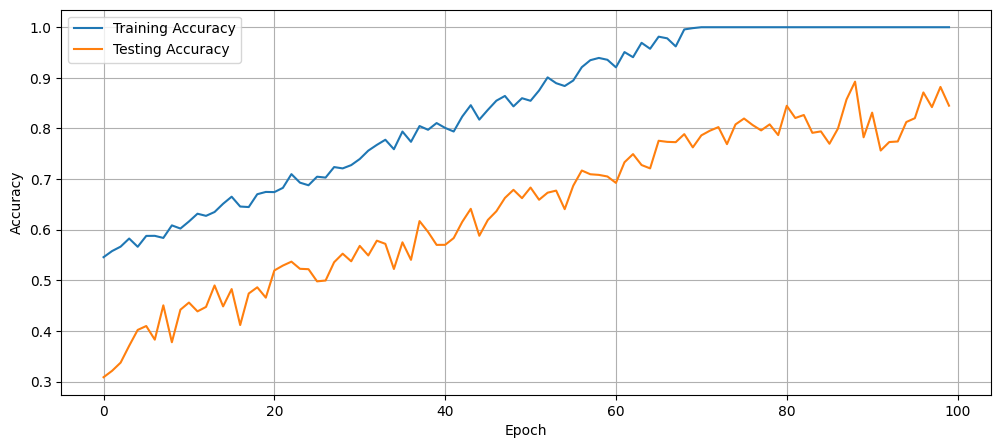

In [ ]:
#   Training and Testing Accuracy

plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Testing Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

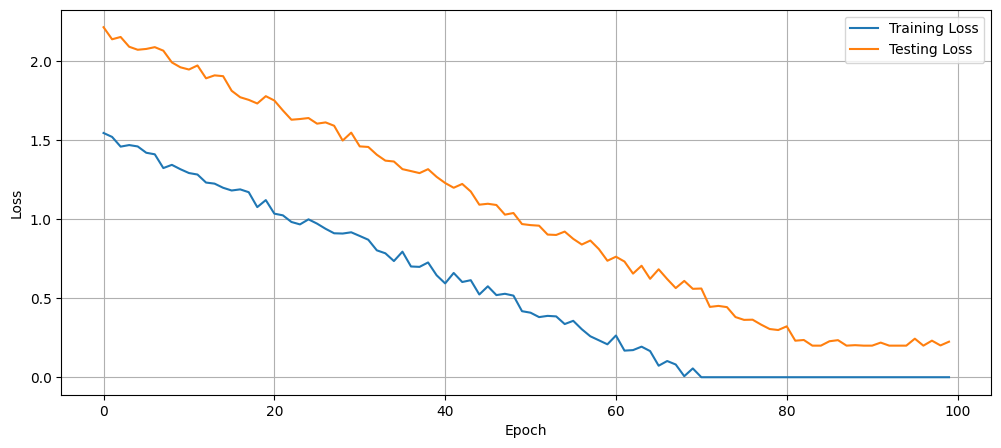

In [ ]:
#   Training and Testing Loss

plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

lime adjustment


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

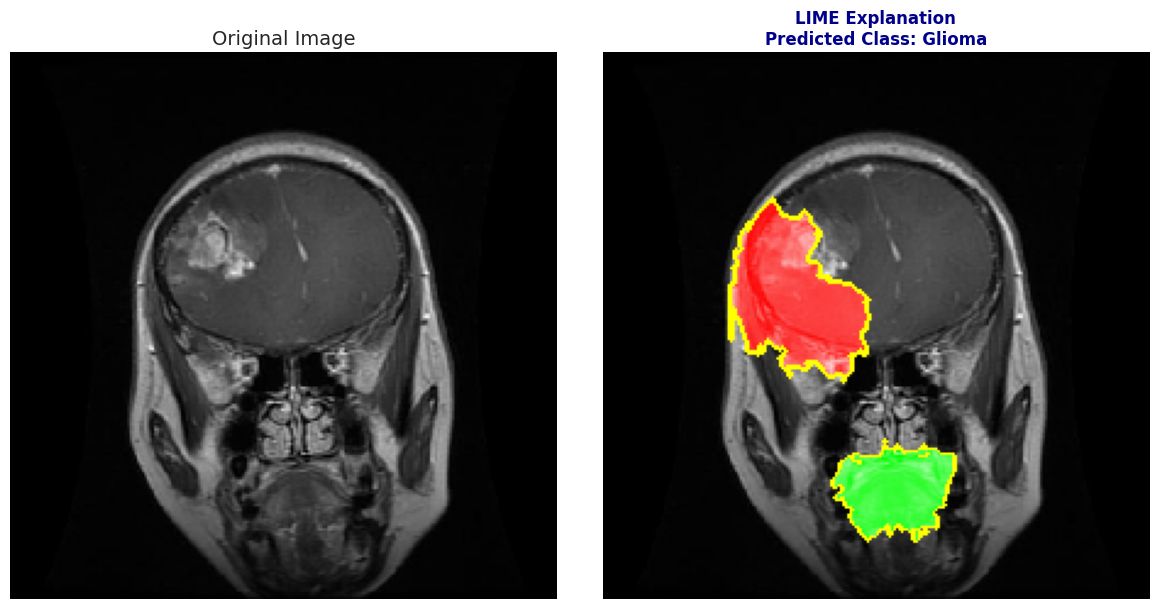

In [ ]:
#   Generating LIME Explanations for Brain Tumor Classification

import lime
import lime.lime_image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.segmentation import mark_boundaries
from skimage.segmentation import quickshift

# Set Seaborn style for better visualization
sns.set_style("whitegrid")

# Load and preprocess the sample MRI image
sample_image = '/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0000.jpg'
image = tf.keras.preprocessing.image.load_img(sample_image, target_size=(224, 224))  # Load image with target size
image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize pixel values to [0,1]

# Convert image to the required format for LIME (without batch dimension)
image_array_no_batch = image_array.astype('double')

# Define a prediction function for LIME explanation
def model_predict(images):
    images = np.array(images)  # Convert list of images to NumPy array
    images = images.reshape((-1, 224, 224, 3))  # Reshape to match model input format (batch_size, 224, 224, 3)
    return model.predict(images)  # Get model predictions

# Get predicted class label for the input image
predictions = model_predict([image_array_no_batch])  # Predict on single image
predicted_class_idx = np.argmax(predictions)  # Get the index of the highest probability class

# Define class labels
class_labels = ["Glioma", "Meningioma", "Pituitary", "No Tumor"]
predicted_class_name = class_labels[predicted_class_idx]  # Get class name based on index

# Initialize LIME explainer using quickshift segmentation
explainer = lime.lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_array_no_batch,  # Image to explain
    model_predict,  # Model prediction function
    top_labels=1,  # Focus on the top predicted label
    hide_color=0,  # Background color for hidden parts
    num_samples=1000,  # Number of perturbed samples for LIME analysis
    segmentation_fn=lambda img: quickshift(img, kernel_size=3, max_dist=300, ratio=0.2)  # Segmentation function
)

# Generate LIME explanation with highlighted boundaries
lime_img, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Use the top predicted label
    positive_only=False,  # Highlight both positive and negative contributions
    num_features=2,  # Number of features to highlight
    hide_rest=False  # Show entire image with masked areas highlighted
)

# Overlay LIME mask on the original image to highlight important regions
highlighted_image = mark_boundaries(lime_img, mask)

# Create a side-by-side plot for better visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original MRI image
ax[0].imshow(image_array)
ax[0].set_title("Original Image", fontsize=14)
ax[0].axis("off")

# Display the LIME-explained image with highlighted areas
ax[1].imshow(highlighted_image)
ax[1].set_title(f"LIME Explanation\nPredicted Class: {predicted_class_name}", 
                fontsize=12, fontweight='bold', color='darkblue')
ax[1].axis("off")

# Adjust layout and show the final visualization
plt.tight_layout()
plt.show()


In [ ]:
#   Evaluating LIME Explanations Using Fidelity, Stability, Localization, and Sparsity Metrics

def generate_ground_truth_mask(image_path, target_size=(224, 224)):
    """
    Generates a binary ground truth mask for a given tumor image by applying thresholding
    and morphological operations to remove noise, then resizes it to the target size.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    _, binary_mask = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)  # Apply thresholding to segment the tumor

    # Perform morphological operations (opening and closing) to remove small noise artifacts
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Resize the binary mask to match the model's input size
    binary_mask = cv2.resize(binary_mask, target_size, interpolation=cv2.INTER_NEAREST)

    return binary_mask // 255  # Normalize to binary format (0s and 1s)

def fidelity_score(explainer, image, model_predict, top_label, num_samples=1000):
    """
    Computes the Fidelity Score by comparing the model's prediction on the original image
    versus the perturbed image generated by LIME.
    """
    explanation = explainer.explain_instance(image, model_predict, top_labels=4, num_samples=num_samples)
    lime_img, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=True)

    # Get predictions for both original and LIME-perturbed images
    original_pred = model_predict([image])[0, top_label]
    masked_pred = model_predict([lime_img])[0, top_label]

    # Fidelity score is the absolute difference between original and perturbed predictions
    return abs(original_pred - masked_pred)

def stability_score(explainer, image, model_predict, num_samples=1000, perturbations=5):
    """
    Measures the stability of LIME explanations by computing the variance of feature attributions
    across multiple runs.
    """
    masks = []
    for _ in range(perturbations):
        explanation = explainer.explain_instance(image, model_predict, top_labels=4, num_samples=num_samples)
        _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=True)
        masks.append(mask.flatten())  # Flatten the mask for easier comparison

    mean_mask = np.mean(masks, axis=0)
    
    # Stability is measured as 1 - standard deviation (lower variance = higher stability)
    return 1 - np.std(mean_mask)

def localization_accuracy(mask, ground_truth_mask):
    """
    Computes the Intersection over Union (IoU) between the LIME mask and the ground truth mask.
    Higher IoU indicates better localization of important regions.
    """
    intersection = np.logical_and(mask, ground_truth_mask).sum()
    union = np.logical_or(mask, ground_truth_mask).sum()

    return intersection / union if union > 0 else 0  # Avoid division by zero

def explanation_sparsity(mask):
    """
    Measures sparsity of LIME explanations as the proportion of non-highlighted pixels.
    Higher sparsity indicates fewer regions were deemed important.
    """
    return np.sum(mask == 0) / mask.size  # Fraction of pixels that are not highlighted

# Generate ground truth mask for evaluation
ground_truth_mask = generate_ground_truth_mask(sample_image, target_size=(224, 224))

# Compute different explanation evaluation metrics
fidelity = fidelity_score(explainer, image_array_no_batch, model_predict, predicted_class_idx)
stability = stability_score(explainer, image_array_no_batch, model_predict)
localization = localization_accuracy(mask, ground_truth_mask)
sparsity = explanation_sparsity(mask)

# Print the computed evaluation metrics
print(f"Fidelity Score: {fidelity}")
print(f"Stability Score: {stability}")
print(f"Localization Accuracy (IoU): {localization}")
print(f"Explanation Sparsity: {sparsity}")


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━